# 載入所需套件

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas_datareader import data as pdr
import yfinance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

# 利用Yfinance下載歷史股價資料並檢視

In [3]:
data = yf.download('SPY', start="2017-01-01")
data.to_csv('SPY.csv',index=False)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,203.788040,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,205.000412,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,204.837616,78379000
2017-01-06,226.529999,227.750000,225.899994,227.210007,205.570435,71559900
2017-01-09,226.910004,227.070007,226.419998,226.460007,204.891861,46939700


# 定義交易條件以及參數

In [4]:
df= data.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

# 設定交易頻率以及初始資金

In [5]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

C:\Users\npc94\AppData\Local\Temp\ipykernel_16260\906370253.py:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
C:\Users\npc94\AppData\Local\Temp\ipykernel_16260\906370253.py:23: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 10, total rewards: -4.679977.3, cost: 0.484374, total money: 9995.320023
epoch: 20, total rewards: -12.529938.3, cost: 0.314398, total money: 9987.470062
epoch: 30, total rewards: -2.800003.3, cost: 0.238481, total money: 9997.199997
epoch: 40, total rewards: -13.790024.3, cost: 0.187638, total money: 9986.209976
epoch: 50, total rewards: -4.360016.3, cost: 0.163105, total money: 9995.639984
epoch: 60, total rewards: -16.519989.3, cost: 0.143681, total money: 9983.480011
epoch: 70, total rewards: 54.710052.3, cost: 0.179785, total money: 10054.710052
epoch: 80, total rewards: -31.280014.3, cost: 0.115392, total money: 9968.719986
epoch: 90, total rewards: 47.010025.3, cost: 0.144749, total money: 10047.010025
epoch: 100, total rewards: -36.890015.3, cost: 0.331225, total money: 9963.109985
epoch: 110, total rewards: -151.610001.3, cost: 0.095386, total money: 9848.389999
epoch: 120, total rewards: 30.659897.3, cost: 0.109667, total money: 10030.659897
epoch: 130, total rewards: 

# 交易紀錄

In [6]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 225.240005, total balance 9774.759995
day 1, sell 1 unit at price 226.580002, investment 0.594919 %, total balance 10001.339996,
day 13: buy 1 unit at price 226.149994, total balance 9775.190002
day 14, sell 1 unit at price 227.600006, investment 0.641173 %, total balance 10002.790009,
day 20: buy 1 unit at price 227.619995, total balance 9775.170013
day 21, sell 1 unit at price 227.770004, investment 0.065903 %, total balance 10002.940018,
day 22: buy 1 unit at price 229.339996, total balance 9773.600021
day 23, sell 1 unit at price 228.929993, investment -0.178775 %, total balance 10002.530014,
day 47: buy 1 unit at price 237.809998, total balance 9764.720016
day 48, sell 1 unit at price 236.899994, investment -0.382660 %, total balance 10001.620010,
day 51: buy 1 unit at price 237.029999, total balance 9764.590012
day 52, sell 1 unit at price 236.770004, investment -0.109688 %, total balance 10001.360016,
day 53: buy 1 unit at price 233.729996, total balan

# 將交易結果繪圖顯示

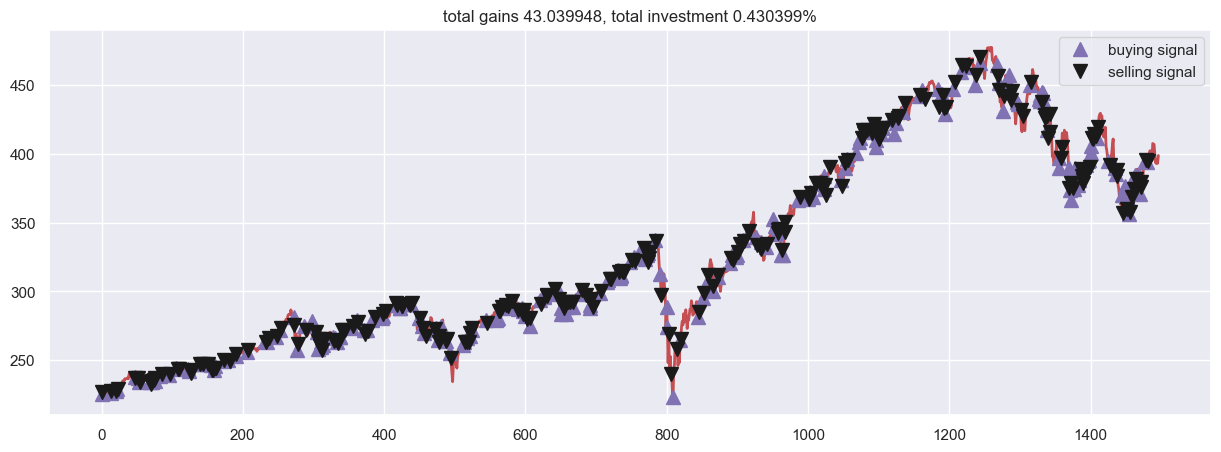

In [7]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()